<a href="https://colab.research.google.com/github/KhotNoorin/Algorithm-practice/blob/main/Encoder_Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: Noorin Nasir Khot

ID: 2024KPAD1007

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [ ]:
#Sample Dataset
data = [
    ("Hello", "नमस्ते"),
    ("How are you?", "आप कैसे हैं?"),
    ("I am fine", "मैं ठीक हूँ"),
    ("What is your name?", "आपका नाम क्या है?"),
    ("My name is John", "मेरा नाम जॉन है"),
    ("Nice to meet you", "आपसे मिलकर खुशी हुई"),
    ("Thank you", "धन्यवाद"),
    ("Good morning", "सुप्रभात"),
    ("Good night", "शुभ रात्रि"),
    ("See you later", "फिर मिलेंगे"),
    ("Yes", "हाँ"),
    ("No", "नहीं"),
    ("Where are you?", "आप कहाँ हैं?"),
    ("I am here", "मैं यहाँ हूँ"),
    ("Come with me", "मेरे साथ आओ"),
    ("Sit down", "बैठ जाओ"),
    ("Stand up", "खड़े हो जाओ"),
    ("Don't worry", "चिंता मत करो"),
    ("Let's go", "चलो")
]

eng_sentences = [x[0] for x in data]
hin_sentences = ['<start> ' + x[1] + ' <end>' for x in data]

In [ ]:
#Tokenization and Padding (Fixed for <start>/<end>)
eng_tokenizer = Tokenizer()
hin_tokenizer = Tokenizer(filters='')

# Fit tokenizers
eng_tokenizer.fit_on_texts(eng_sentences)
hin_tokenizer.fit_on_texts(hin_sentences)

# Convert to sequences
eng_seq = eng_tokenizer.texts_to_sequences(eng_sentences)
hin_seq = hin_tokenizer.texts_to_sequences(hin_sentences)

# Pad sequences
max_eng_len = max(len(s) for s in eng_seq)
max_hin_len = max(len(s) for s in hin_seq)

eng_seq = pad_sequences(eng_seq, maxlen=max_eng_len, padding='post')
hin_seq = pad_sequences(hin_seq, maxlen=max_hin_len, padding='post')

# Prepare decoder input/output
decoder_input = hin_seq[:, :-1]
decoder_output = hin_seq[:, 1:]
decoder_output = np.expand_dims(decoder_output, -1)

# Vocabulary sizes
eng_vocab = len(eng_tokenizer.word_index) + 1
hin_vocab = len(hin_tokenizer.word_index) + 1

print("English Vocab Size:", eng_vocab)
print("Hindi Vocab Size:", hin_vocab)

English Vocab Size: 38
Hindi Vocab Size: 42


In [ ]:
#Build the Seq2Seq Model
latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(max_eng_len,))
enc_emb = Embedding(eng_vocab, latent_dim)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state=True)(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_hin_len - 1,))
dec_emb_layer = Embedding(hin_vocab, latent_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=False)
decoder_outputs = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(hin_vocab, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define full model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 4)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_11            │ (None, 5)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_6 (Embedding)   │ (None, 4, 256)         │          9,728 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 5, 256)         │         10,752 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ [(None, 256), (None,   │        525,312 │ embedding_6[0][0]      │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ (None, 5, 256)         │        525,312 │ embedding_7[0][0],     │
│                           │                        │                │ lstm_6[0][1],          │
│                           │                        │                │ lstm_6[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 5, 42)          │         10,794 │ lstm_7[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,081,898 (4.13 MB)

 Trainable params: 1,081,898 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Train the Model
history = model.fit(
    [eng_seq, decoder_input],
    decoder_output,
    batch_size=4,
    epochs=200,
    verbose=1
)

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 3.7051
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 3.4402
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.5914
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 2.3534
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 2.1574
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 2.1130
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 2.0857
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 1.9605
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1.9418
Epoch 10/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.6722
Epoch 11/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.9596
Epoch 12/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.7900
Epoch 13/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.7761
Epoch 14/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.5370
Epoch 15/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.3829
Epoch 16/200
5/5 

In [ ]:
#Inference Models
# Encoder model
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder model
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states_inputs
)

In [ ]:
#Translation Function
reverse_hin_index = {v: k for k, v in hin_tokenizer.word_index.items()}
reverse_eng_index = {v: k for k, v in eng_tokenizer.word_index.items()}

def translate(sentence):
    seq = eng_tokenizer.texts_to_sequences([sentence])
    seq = pad_sequences(seq, maxlen=max_eng_len, padding='post')
    states = encoder_model.predict(seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = hin_tokenizer.word_index['<start>']

    decoded_sentence = ''
    stop_condition = False
    max_output_len = max_hin_len
    prev_words = []

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_hin_index.get(sampled_token_index, '')

        # Repetition and stop condition detection
        if (sampled_word == '<end>' or sampled_word == '' or
            len(decoded_sentence.split()) >= max_output_len or
            prev_words.count(sampled_word) >= 1):
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word
            prev_words.append(sampled_word)

            # Shift window to check only last few words for repetition
            if len(prev_words) > 5:
                prev_words.pop(0)

            target_seq[0, 0] = sampled_token_index
            states = [h, c]

    return decoded_sentence.strip()

In [ ]:
#Test Translations
test_sentences = [
    "Hello",
    "Thank you",
    "Where are you?",
    "Come with me"
]

for sent in test_sentences:
    print(f"{sent}  {translate(sent)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Hello  नमस्ते
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Thank you  धन्यवाद
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Where are you?  आप
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Come with me  मेरे साथ


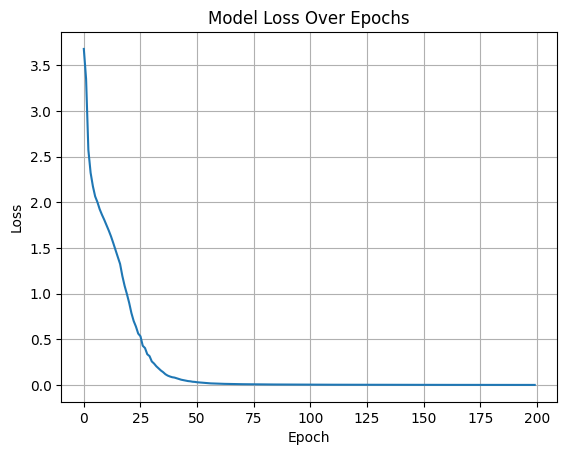

In [ ]:
#Plot Training Loss
plt.plot(history.history['loss'])
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()